# Adults Census Model Training with Sagemaker Scikit-learn 
## Support Vector Machines Algorithm

This notebook used to experiment Scikit-learn with Sagemaker by utilizing the pre-built container.

Scikit-learn is on of Python machine learning framework, that composed of algorithms for classification, regression, clustering, dimensionality reduction, and data/feature pre-processing.
Scikit-learn container: https://github.com/aws/sagemaker-scikit-learn-container

SageMaker Python SDK is an open source library for training and deploying machine learning models on Amazon SageMaker: https://github.com/aws/sagemaker-python-sdk

With SageMaker Python SDK:
- train and deploy models using popular deep learning frameworks eg. MXNet, TensorFlow, PyTorch
- train and deploy models with built in Amazon algorithms eg. Scikit-learn, XGBoost
- train and deploy model using your own algorithms built into SageMaker compatible Docker containers.

using Sagemaker python sdk with existing scikit-learn code to train model on the Adult Census Income Binary classfication dataset and evaluate the performance of the model.

## Outline

1. Setup Development Environment
2. Data Preparation
3. Model Training
4. Model Comparison

### 1 Set up Development Environment

Steps:
- Import base Amazon SageMaker ML packages
- Check the SDK version
- Create S3 bucket

In [1]:
# base packages to work with SageMaker
import boto3
from sagemaker import get_execution_role
import sagemaker

# check core SDK version number
print("Ready to use Amazon SageMaker", sagemaker.__version__)

Ready to use Amazon SageMaker 2.16.4.dev0


In [2]:
# S3 prefix
prefix = 'Scikit-adults'

# Now let's define the S3 bucket
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
print(f'Using S3 bucket: {bucket}' )

Using S3 bucket: sagemaker-us-east-2-359732627051


In [3]:
# Python libraries that we'll use throughout the analysis
import os
import datetime
import time
import tarfile
import pandas as pd
import numpy as np

### 2. Data Preparation
We download Adult Census Income Binary classfication dataset from github, prepreocessing, split it and send it to S3

- 2.1 Download dataset

- 2.2 Upload data to Amazon S3 bucket

Dataset: https://archive.ics.uci.edu/ml/datasets/Adult

#### 2.1 Download Adult Data Set

In [4]:
## read the data
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header = None, na_values=' ?')

## read test data
data_test = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", header = None, skiprows=1, na_values=' ?')

## set column names
data.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

data_test.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

In [5]:
np.unique(data.loc[:,'IncomeGroup'].values.tolist())

array([' <=50K', ' >50K'], dtype='<U6')

In [6]:
np.unique(data_test.loc[:,'IncomeGroup'].values.tolist())

array([' <=50K.', ' >50K.'], dtype='<U7')

In [7]:
from sklearn.preprocessing import LabelEncoder

# preprocess
le = LabelEncoder()
data.loc[:,'IncomeGroup'] = le.fit_transform(data.loc[:,'IncomeGroup'].values.tolist())
data_test.loc[:,'IncomeGroup'] = le.fit_transform(data_test.loc[:,'IncomeGroup'].values.tolist())

# Combine the two datasets to convert the categorical values to binary indicators
data_combined = pd.concat([data, data_test])
data_combined.shape

(48842, 15)

In [8]:
# drop rows with missing
data_combined = data_combined.dropna()
data_combined.shape

(45222, 15)

In [9]:
data_combined.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [10]:
np.unique(data_combined.loc[:,'IncomeGroup'].values.tolist())

array([0, 1])

In [20]:
# summarize the class distribution
import collections

target = data_combined.values[:,-1]
counter = collections.Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=34014, Percentage=75.216%
Class=1, Count=11208, Percentage=24.784%


In [41]:
cat_ix = data_combined.select_dtypes(include=['object', 'bool']).columns
cat_ix

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [43]:
num_ix = data_combined.select_dtypes(include=['int64', 'float64']).columns
num_ix

Index(['IncomeGroup', 'age', 'fnlwgt', 'education-num', 'capital-gain',
       'capital-loss', 'hours-per-week'],
      dtype='object')

In [27]:
# Create directory
os.makedirs('./data', exist_ok=True)

# write csv
data_combined.to_csv("./data/adult.csv", index = False)

#### 2.2 Upload data to Amazon S3 bucket

Here we will send data to S3 and then SageMaker will take training data from s3.

In [28]:
WORK_DIRECTORY = 'data'

train_input = sess.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY))
train_input

's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'

### 3 Model Training

#### 3.1 Prepare a training script
The below script contains training model and can run (model training) both in SageMaker hardware for model training or locally (desktop, SageMaker notebook, etc)

In [29]:
# Directory to write training script.
# Code Directory
import os
script_folder = os.path.join(os.getcwd(), "script")
os.makedirs(script_folder, exist_ok=True)

In [54]:
%%writefile $script_folder/train_adult_SVC.py
import os
import argparse
import joblib
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

if __name__ =='__main__':
    
    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters will be passed as arguments to the script.
    # example: sklearn SVC hyperparameters
    parser.add_argument('--max-iter', type=int, default=1000)
    
    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--features', type=str)  # required name features for flexibity
    parser.add_argument('--target', type=str, default='IncomeGroup')

    args, _ = parser.parse_known_args()
    print(f"--model-dir: {args.model_dir}")
    print(f"--train: {args.train}")
    
    # Take the set of files and read them all into a single pandas dataframe
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))
    raw_data = [ pd.read_csv(file, engine="python") for file in input_files ]
    df = pd.concat(raw_data)
    print(df.head())
          
    #Prepocessing
    X = df.drop('IncomeGroup', axis=1)
    y = df['IncomeGroup']
    
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    print(f"cat_ix: {cat_ix}")
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    print(f"num_ix: {num_ix}")
    
    #use stratify for un balanced number of examples for each class label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
    print(f"X_train:{X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train:{y_train.shape}")
    print(f"y_test: {y_test.shape}")
          
    # Model Training: Support Vector Machines
    print('training model')
    MODEL = 'SVC'

    # define steps
    model = SVC(gamma='scale', probability = True, max_iter = args.max_iter)
    steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model a pipeline
    pipe  = Pipeline(steps=[('transformer',ct),('svc',model)])
    pipe.fit(X_train, y_train)
    print(f"model: {pipe}")
          
    ## Evaluate the model

    # using threshold
    threshold = 0.5 # set threshold as 0.5
    y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
    print(f"y_pred: {y_pred}")
    print(f'Misclassified examples:{(y_test != y_pred).sum()}')
    print(pipe.predict_proba(X_test))
          
    print(f"distinct y_pred: {np.unique(y_pred)}")
    print(f"distinct y_test: {np.unique(y_test)}")
          
    # Confusion Matrix
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"confusion matrix:\n {conf_mat}")
    
    # AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f"auc: {auc}")
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}") 
    
    # Precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision}")
    
    # Recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall}")
    
    # F1
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"F1: {f1}")
    
    # classification_report
    print('classification_report')
    print(metrics.classification_report(y_test, y_pred))
        
    # persist model
    path = os.path.join(args.model_dir, f"{MODEL}.joblib")
    joblib.dump(pipe, path)
    print('model persisted at ' + path)

Overwriting /home/ec2-user/SageMaker/script/train_adult_SVC.py


#### 3.2 Train Model

##### 3.2.1 Run locally
Here we can run model Training locally (such as desktop, SageMaker notebook, etc)

script arguments allows us to remove from the script any SageMaker-specific configuration, and run locally

--features 'age fnlwgt education education-num marital-status relationship race sex capital-gain capital-loss hours-per-week' 

In [55]:
! python $script_folder/train_adult_SVC.py --max-iter -1 \
                   --model-dir ./ \
                   --train ./data/ \
                   --features 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'

extracting arguments
--model-dir: ./
--train: ./data/
   age          workclass  fnlwgt  ... hours-per-week  native-country IncomeGroup
0   39          State-gov   77516  ...             40   United-States           0
1   50   Self-emp-not-inc   83311  ...             13   United-States           0
2   38            Private  215646  ...             40   United-States           0
3   53            Private  234721  ...             40   United-States           0
4   28            Private  338409  ...             40            Cuba           0

[5 rows x 15 columns]
cat_ix: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
num_ix: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
X_train:(31655, 14)
X_test: (13567, 14)
y_train:(31655,)
y_test: (13567,)
training model
model: Pipeline(memory=None,
         steps=[('transformer',


##### 3.2.2 Submit the Training Job to the Compute Cluster

Here we can run model Training in SageMaker training hardware.

Training job will show up in the Amazon SageMaker under Training section.

Launching a training job with the Python SDK

We use the Estimator from the SageMaker Python SDK

###### Create a sagemaker.sklearn.SKLearn Estimator

In [56]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    source_dir="./script/",
    entry_point='train_adult_SVC.py',
    role = get_execution_role(),
    instance_type='ml.m5.4xlarge', #
    framework_version='0.20.0',
    base_job_name='binary-classifiation-scikit',
    hyperparameters = {'max-iter': -1,
                       'features': 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
                      })

###### Call the estimator’s fit method

In [59]:
train_input

's3://sagemaker-us-east-2-359732627051/Scikit-adults/data'

In [60]:
# launch training job, with asynchronous call
sklearn_estimator.fit({'train': train_input}, wait=False)

##### 3.2.3 Run locally (My Desktop hardware)
Here we can run model Training locally use my desktop hardware:

###### 3.2.3.1 Setup

In [ ]:
#! pip install watermark

In [27]:
%reload_ext watermark
%watermark

Last updated: 2020-12-07T12:49:09.358738+01:00

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 7
Machine     : AMD64
Processor   : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores   : 4
Architecture: 64bit



In [29]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,sklearn

Author: Habtamu desalegn

Last updated: 2020-12-07

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.19.0

numpy  : 1.19.4
pandas : 1.1.4
scipy  : 1.5.3
sklearn: 0.23.2



In [68]:
# Python libraries 
import os
import time
import collections
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC

###### 3.2.3.2 Data Preparation

In [50]:
## read the data
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header = None, na_values=' ?')

## read test data
data_test = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", header = None, skiprows=1, na_values=' ?')

## set column names
data.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

data_test.columns = ['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'IncomeGroup']

In [51]:
print(np.unique(data.loc[:,'IncomeGroup'].values.tolist()))
print(np.unique(data_test.loc[:,'IncomeGroup'].values.tolist()))

[' <=50K' ' >50K']
[' <=50K.' ' >50K.']


In [52]:
# preprocess

d = {' <=50K': 0,
     ' >50K': 1}
data['IncomeGroup'] = data['IncomeGroup'].map(d)

t = {' <=50K.': 0,
     ' >50K.': 1}
data_test['IncomeGroup'] = data_test['IncomeGroup'].map(t)

# Combine the two datasets to convert the categorical values to binary indicators
data_combined = pd.concat([data, data_test])
c = {0 : ' <=50K',
     1 : ' >50K'}
data_combined['IncomeGroup'] = data_combined['IncomeGroup'].map(c)
print(f"data_combined.shape: {data_combined.shape}")

# drop rows with missing
data_combined = data_combined.dropna()
print(f"data_combined.shape (After dropna): {data_combined.shape}")

# display data
data_combined.head()

data_combined.shape: (48842, 15)
data_combined.shape (After dropna): (45222, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,IncomeGroup
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [53]:
# summarize the class distribution
target = data_combined.values[:,-1]
counter = collections.Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))


Class= <=50K, Count=34014, Percentage=75.216%
Class= >50K, Count=11208, Percentage=24.784%


In [54]:
# Create directory
os.makedirs('./data', exist_ok=True)

# write csv
data_combined.to_csv("./data/adult.csv", index = False)

###### 3.2.3.3 Model Training

In [69]:
start_time = time.time()

df = pd.read_csv("./data/adult.csv")
df.head()
        
#Prepocessing
print('building datasets')
features = 'age workclass fnlwgt education education-num marital-status occupation relationship race sex capital-gain capital-loss hours-per-week native-country'
target = 'IncomeGroup'
X = df[features.split()]
y = df[target]

# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)

cat_ix = X.select_dtypes(include=['object', 'bool']).columns
print(f"cat_ix: {cat_ix}")
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
print(f"num_ix: {num_ix}")

#use stratify for un balanced number of examples for each class label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)
print(f"X_train:{X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test: {y_test.shape}")
  
# Model Training: Support Vector Machines
print('training model')
MODEL = 'SVC'

# define steps
model = SVC(gamma='scale', probability = True, max_iter = -1)
steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model a pipeline
pipe  = Pipeline(steps=[('transformer',ct),('svc',model)])
pipe.fit(X_train, y_train)
print(f"model: {pipe}")
  
## Evaluate the model

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (pipe.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')
print(pipe.predict_proba(X_test))
  
print(f"distinct y_pred: {np.unique(y_pred)}")
print(f"distinct y_test: {np.unique(y_test)}")
  
# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

# persist model
path = f"models/SageMaker/Adult/local/desktop/{MODEL}.joblib"
joblib.dump(pipe, path)
print('model persisted at ' + path)

time_elapsed = (time.time() - start_time)
print("Computational time:{}".format(time_elapsed))

cat_ix: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
num_ix: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
X_train:(31655, 14)
X_test: (13567, 14)
y_train:(31655,)
y_test: (13567,)
training model
model: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('c',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')),
                                                 ('n', MinMaxScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
   

<a id="result"></a>
### 4 Model Comparison

Note: **They are similar**

#### using local hardware

training model
model: Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('c',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex...
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))],
                                   verbose=False)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
y_pred: [1 0 0 ... 0 0 0]
Misclassified examples:2234
[[0.30990163 0.69009837]
 [0.91836543 0.08163457]
 [0.8811164  0.1188836 ]
 ...
 [0.79980888 0.20019112]
 [0.8566972  0.1433028 ]
 [0.87048868 0.12951132]]
distinct y_pred: [0 1]
distinct y_test: [0 1]
confusion matrix:
 [[9545  648]
 [1586 1788]]
auc: 0.733180877586586
Accuracy: 0.8353357411365814
Precision: 0.7339901477832512
Recall: 0.5299347954949615
F1: 0.6154905335628227
classification_report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     10193
           1       0.73      0.53      0.62      3374

    accuracy                           0.84     13567
   macro avg       0.80      0.73      0.76     13567
weighted avg       0.83      0.84      0.83     13567

#### using Sagemaker Training hardware

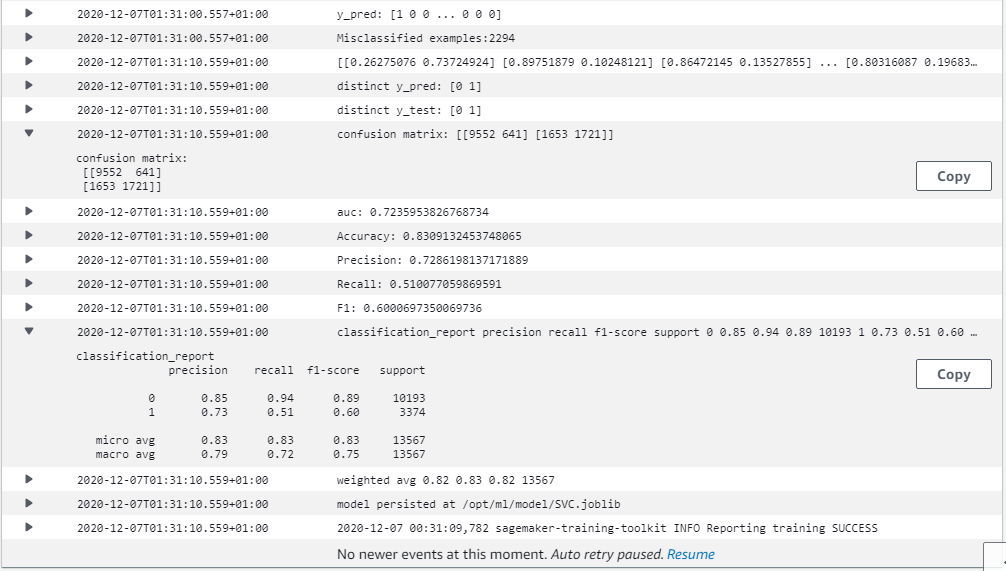

In [2]:
from IPython.display import Image

Image(filename='images/SageMaker/Exp-2/SVC-v3/metric.png')

## Amazon Web service (AWS)

Here are core services used to train in Amazon Cloud:
1. Amazon SageMaker
2. Amazon S3
3. Amazon Cloud Watch

### Amazon SageMaker 

Some  screenshot from training our model

#### Notebook Instance

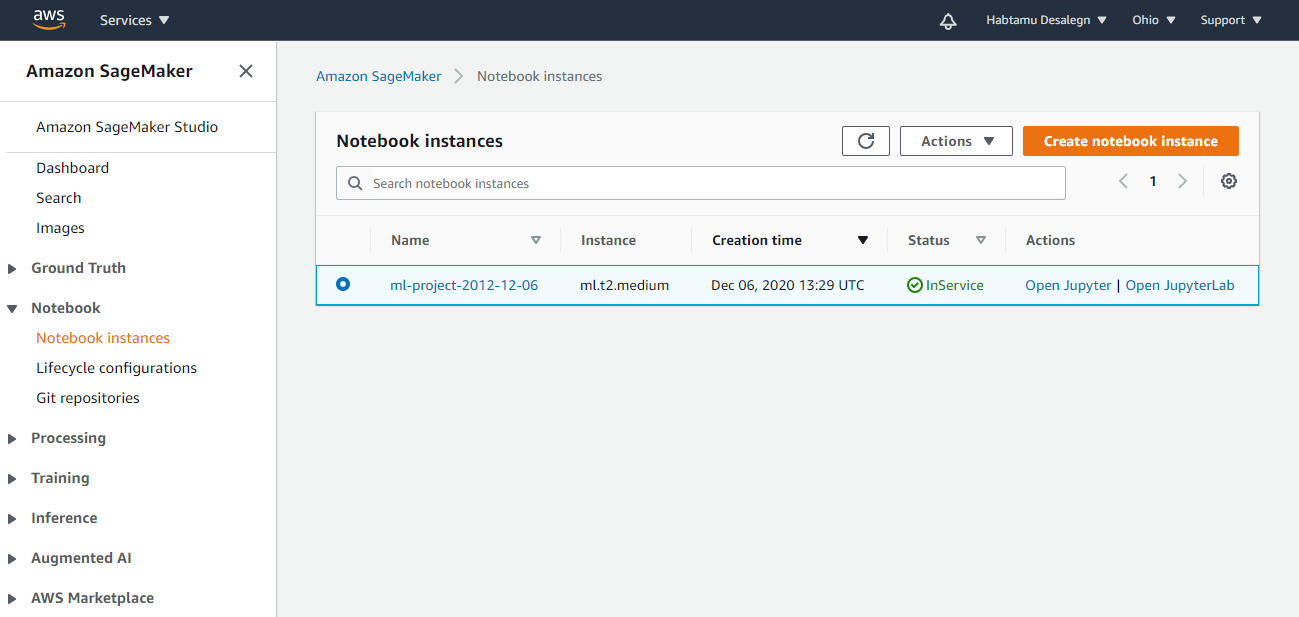

In [3]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/sagemaker-Notebook instance.png')

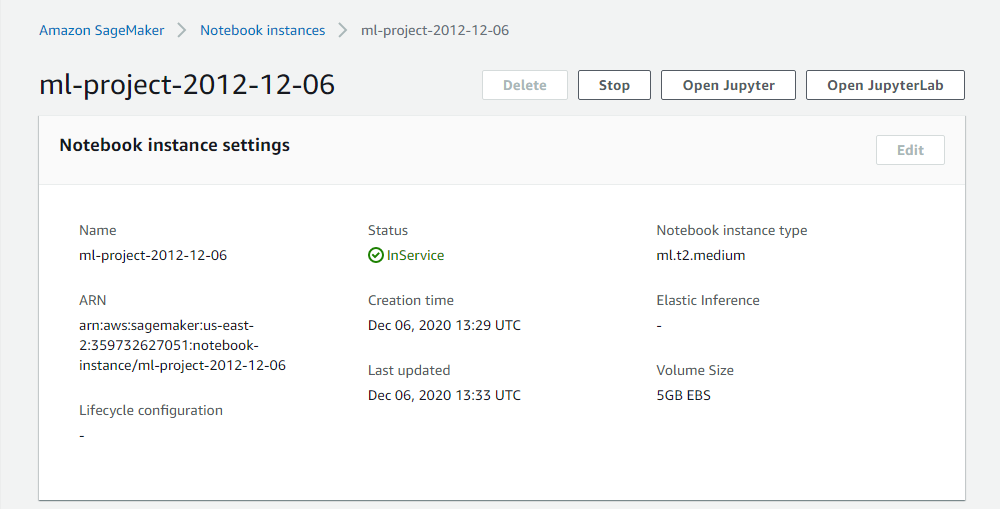

In [4]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/sagemaker-Notebook instance-details.png')

#### Jupyter Notebook

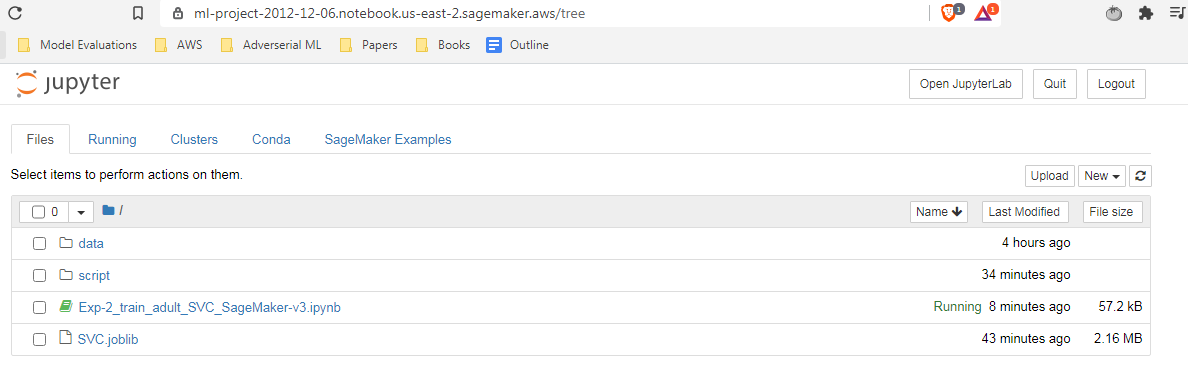

In [6]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/jupyter-home.png')

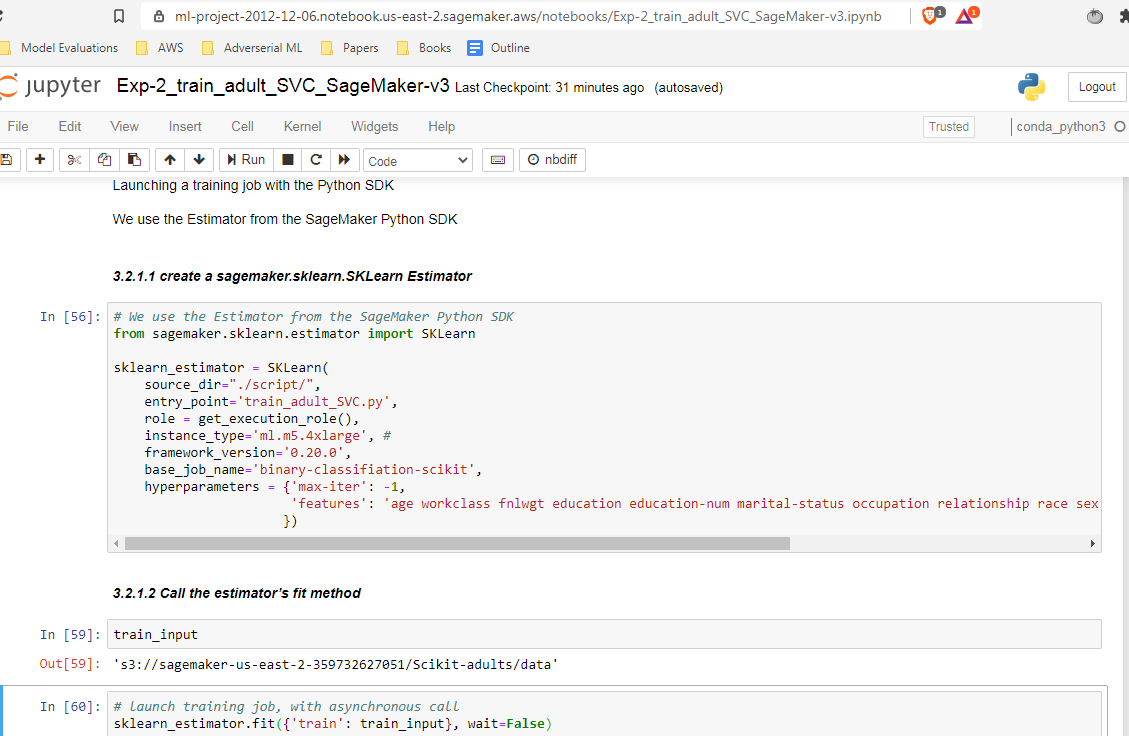

In [7]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/jupyter-notebook.png')

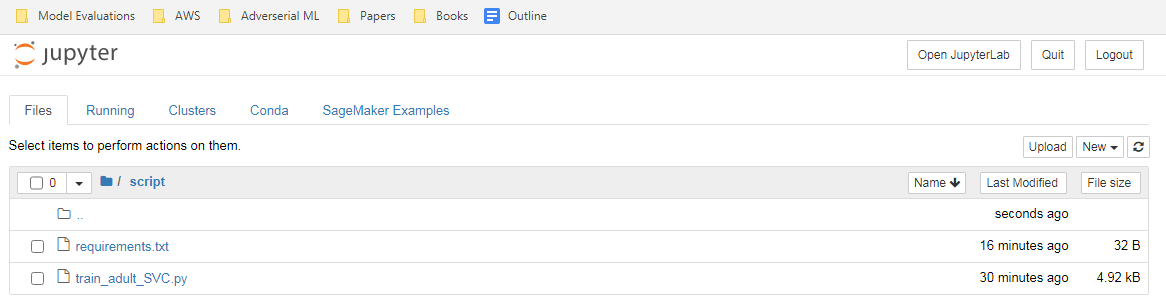

In [8]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/jupyter-script.png')

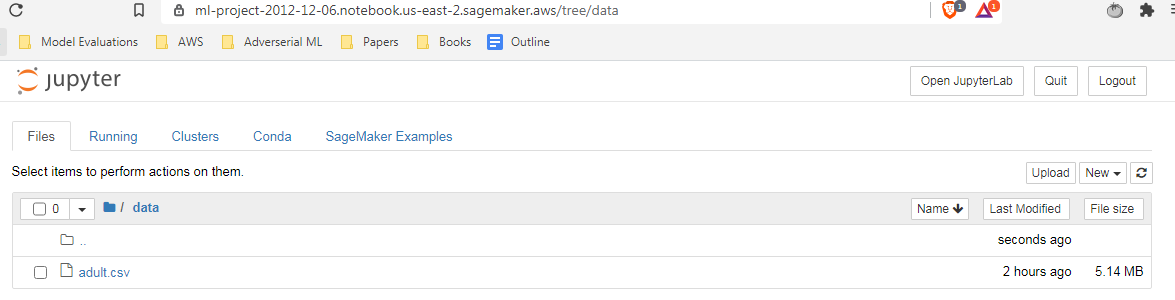

In [9]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Jupyter-data.png')

#### Training jobs

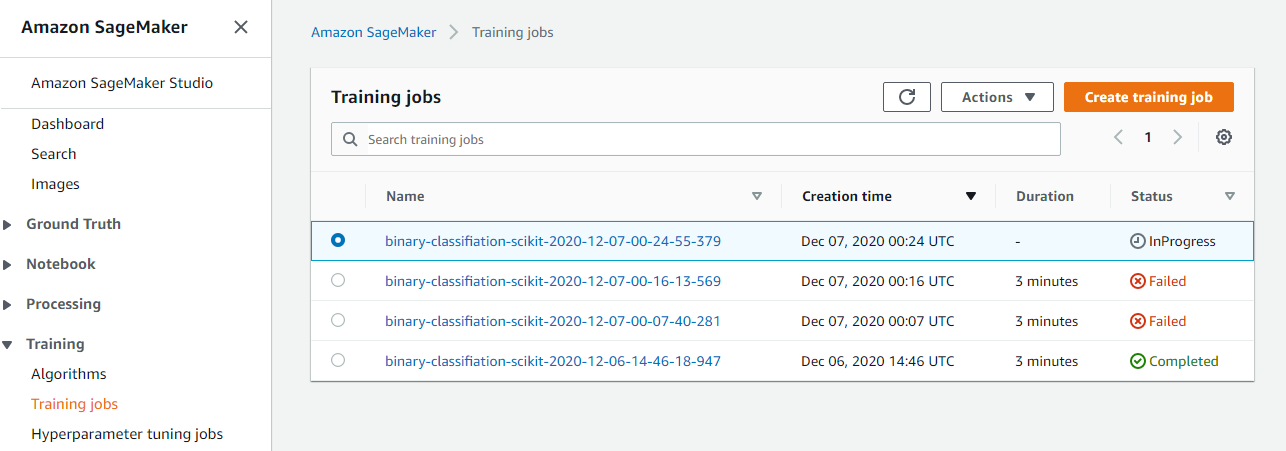

In [10]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-main.png')

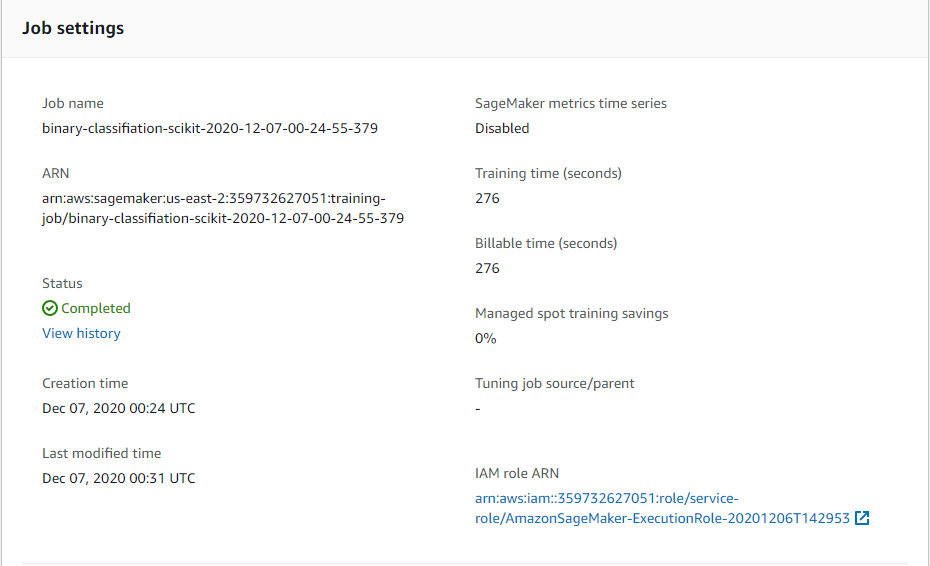

In [11]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-settings.png')

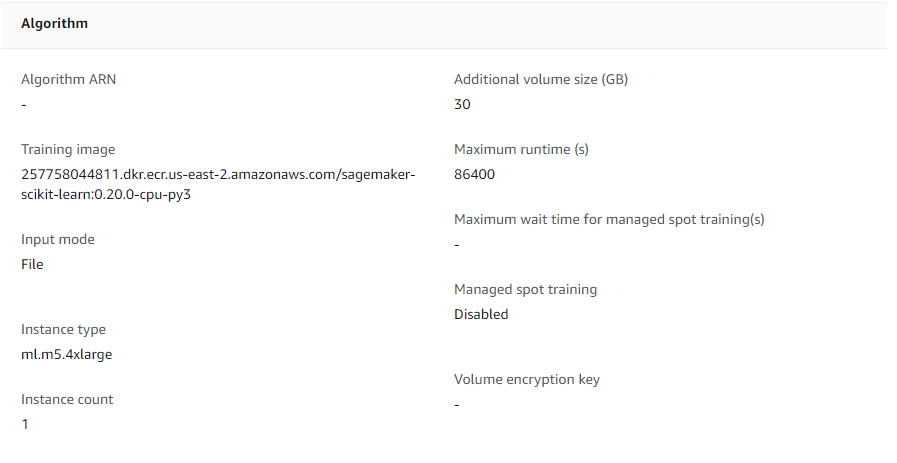

In [12]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-algorithms.png')

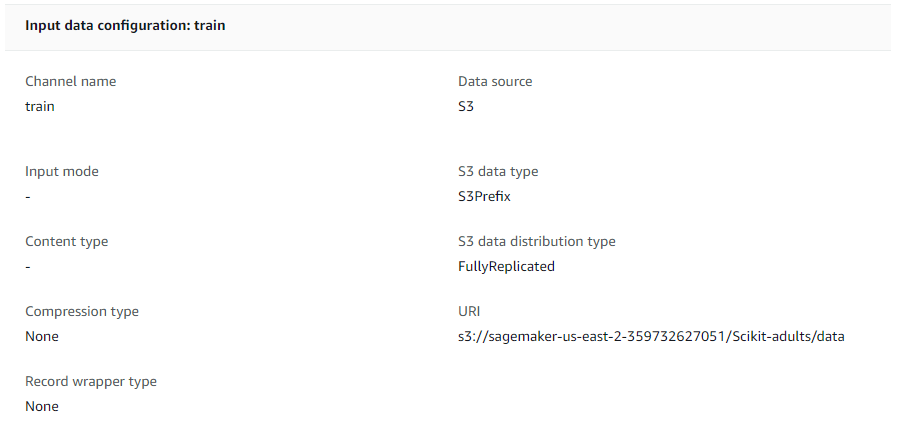

In [13]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-input.png')

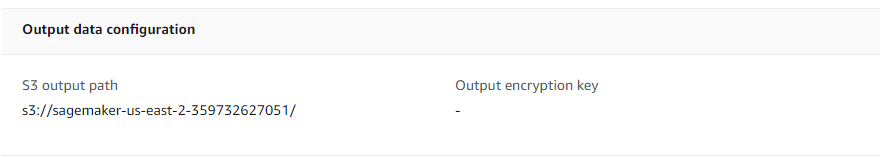

In [14]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-output.png')

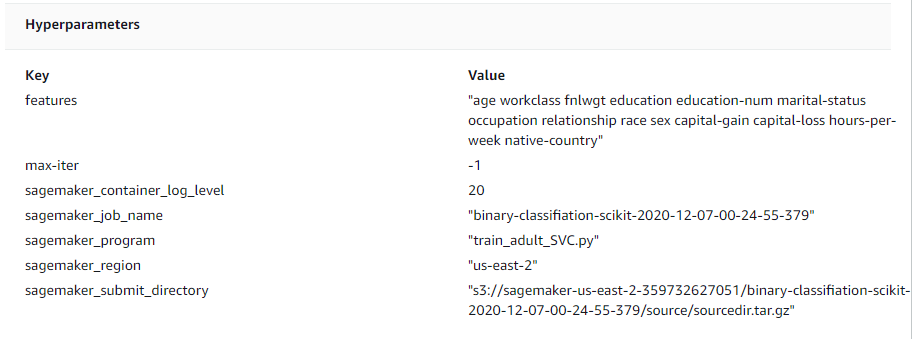

In [15]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-hyperparameters.png')

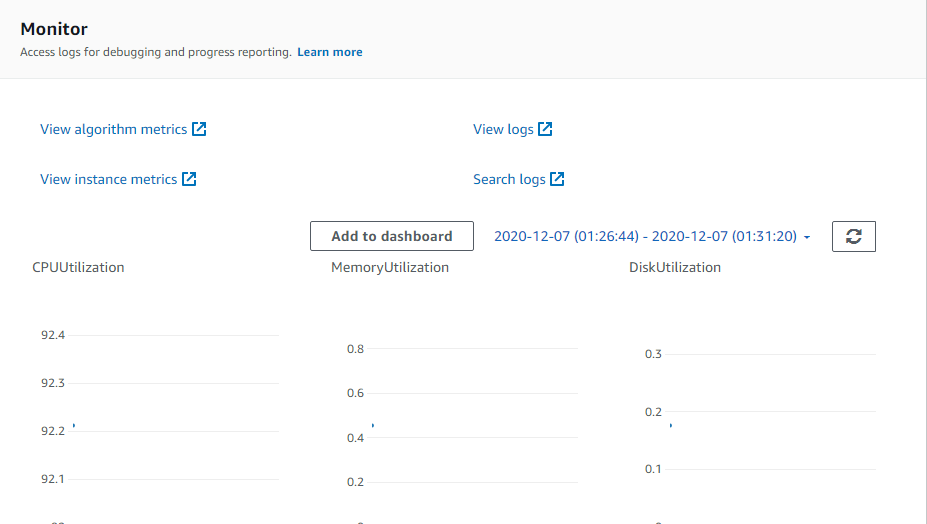

In [16]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/Training-job-monitor.png')

### Amazon S3 

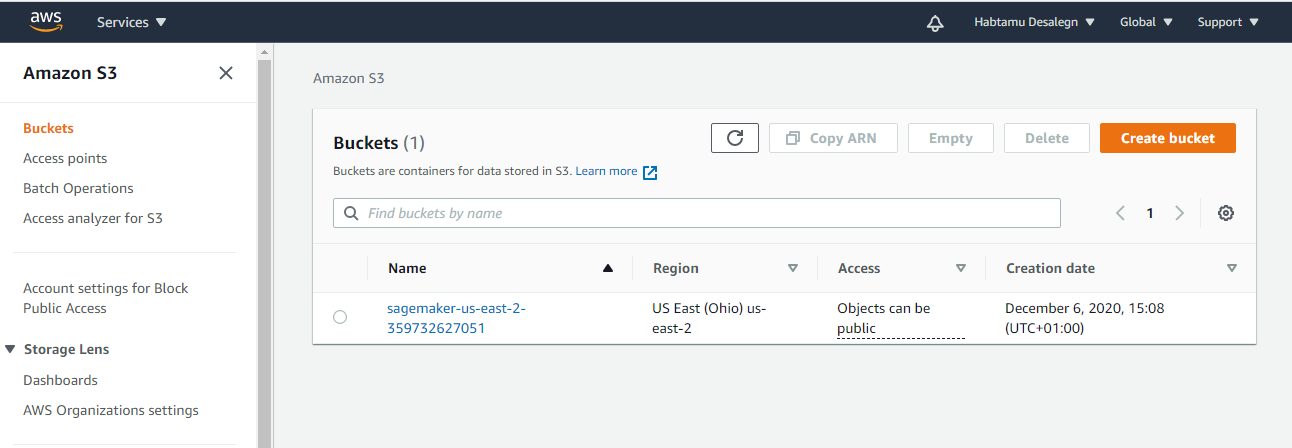

In [17]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/S3-main.png')

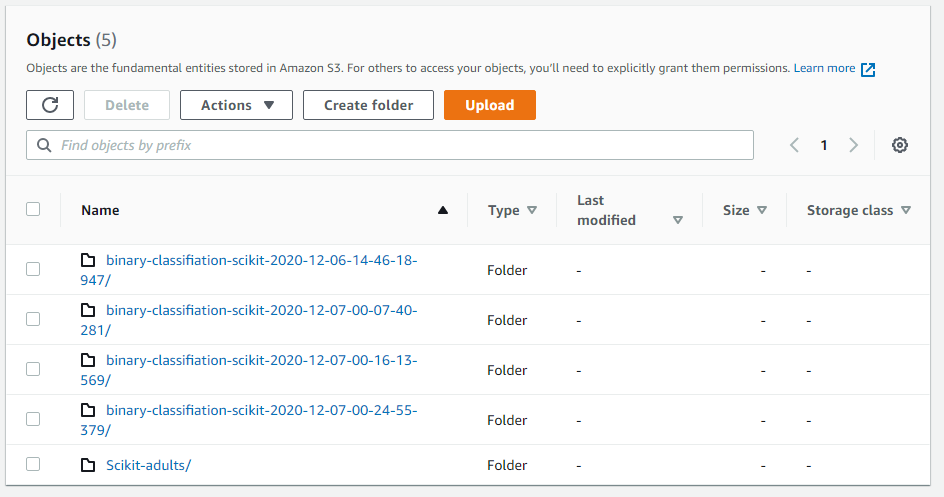

In [18]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/S3-objects.png')

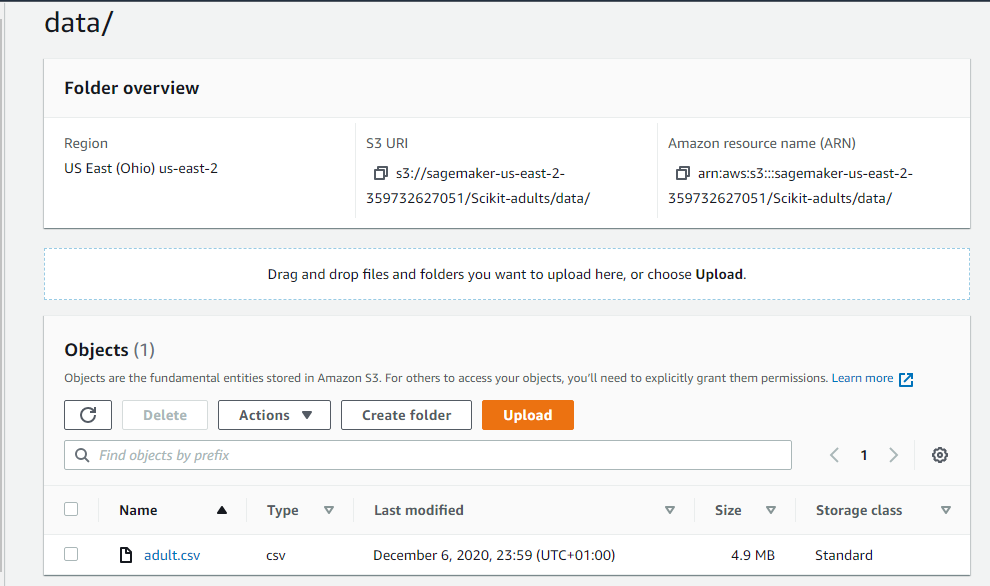

In [19]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/S3-objects-data.png')

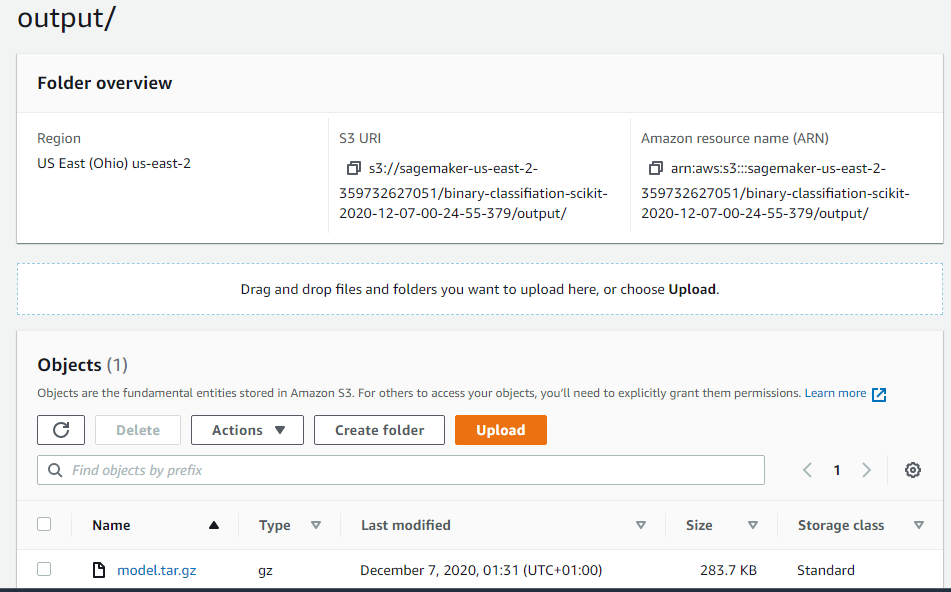

In [20]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/S3-objects-output-model.png')

### Amazon Cloud Watch 

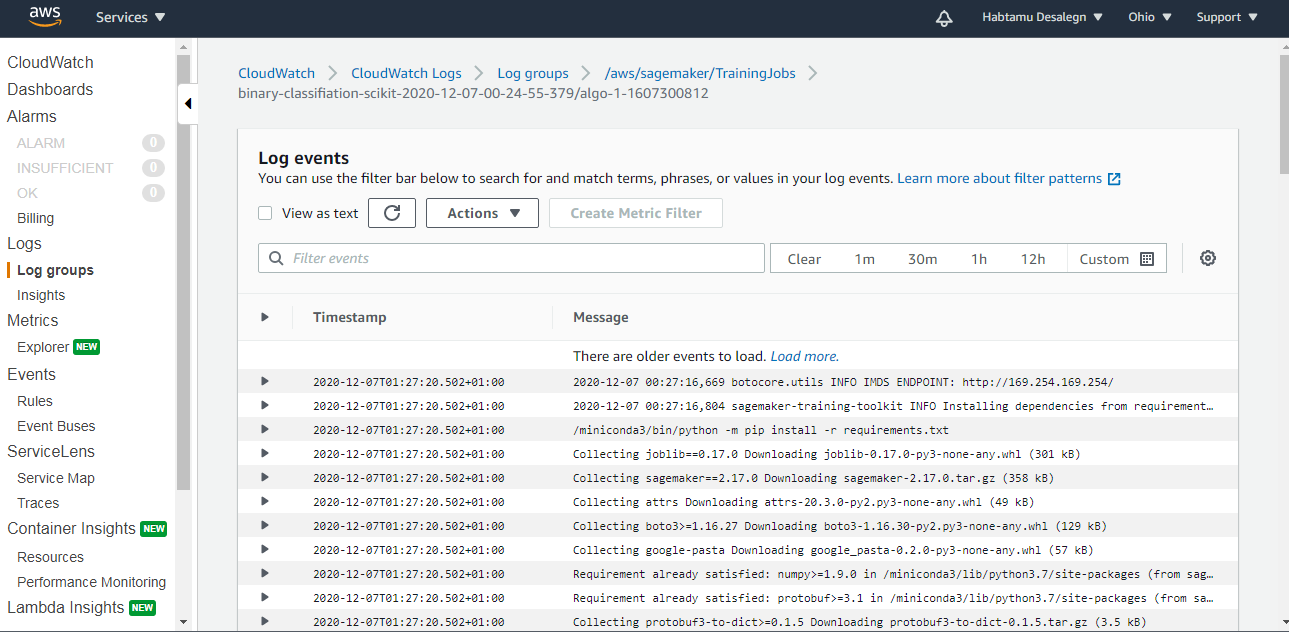

In [21]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/cloudwatch-logevent-1.png')

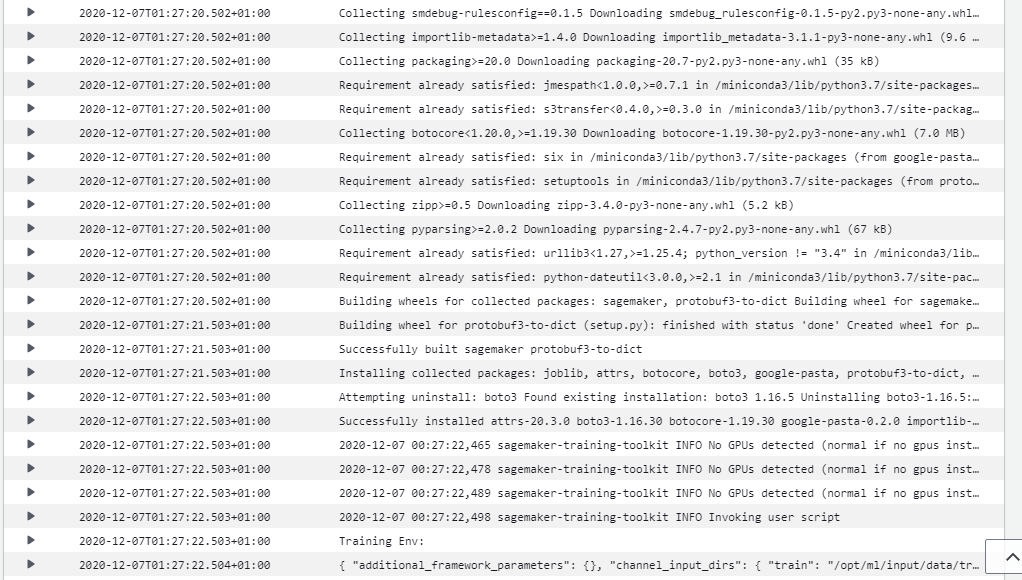

In [22]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/cloudwatch-logevent-2.png')

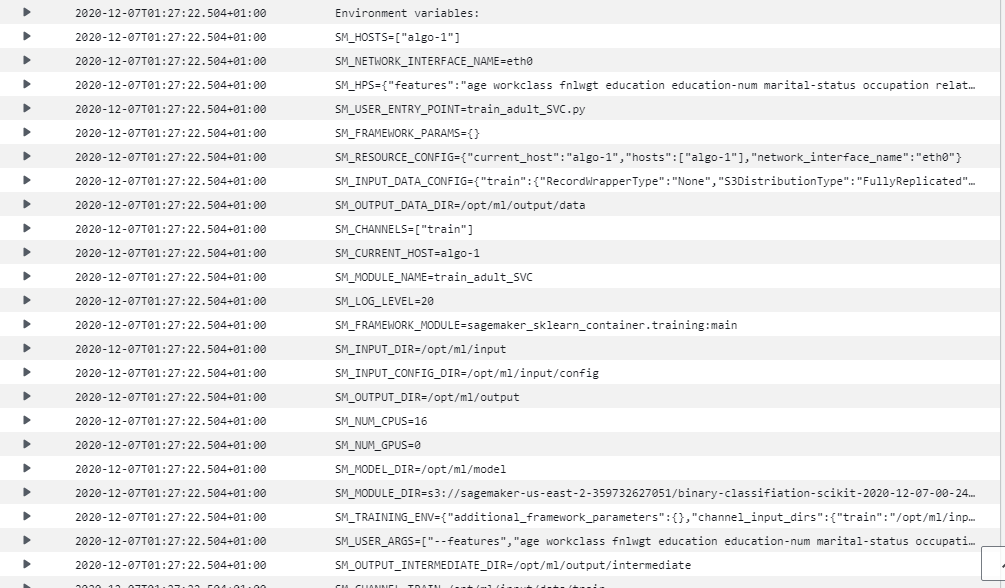

In [23]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/cloudwatch-logevent-3.png')

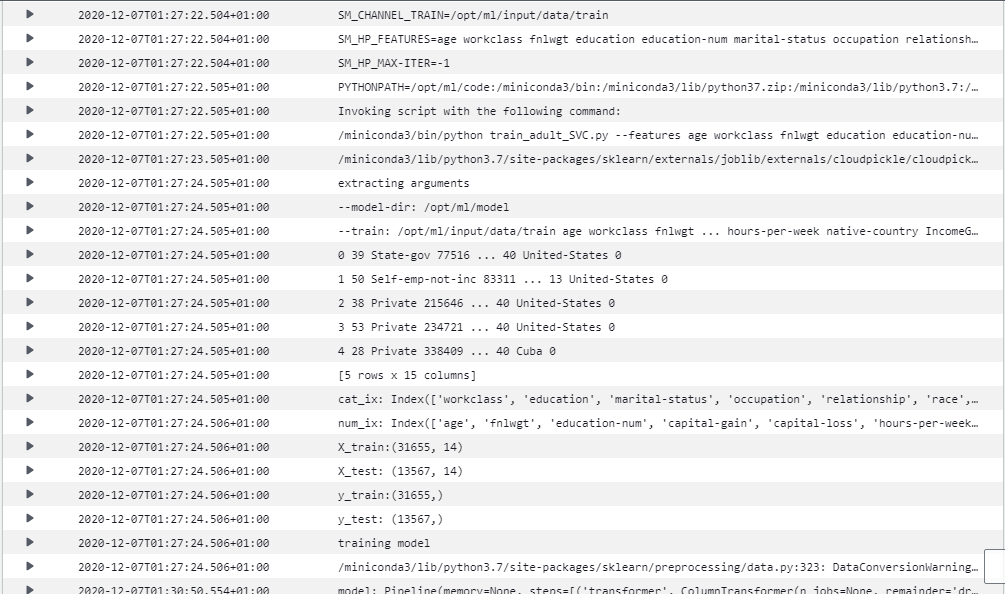

In [24]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/cloudwatch-logevent-4.png')

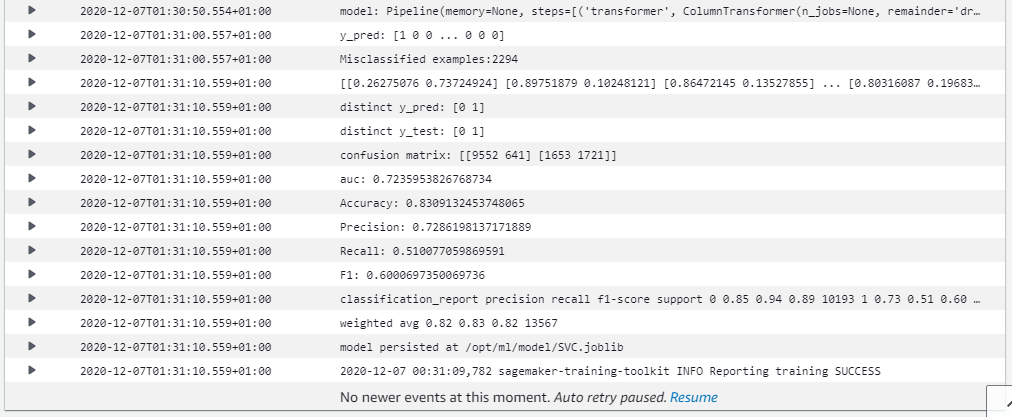

In [25]:
Image(filename='images/SageMaker/Exp-2/SVC-v3/cloudwatch-logevent-5.png')